In this notebook, we will showcase some simple analysis on the output of the physics-based tropical cyclone downscaling mode. First, we will import some standard packages, which should aid in our analysis. 

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

Next, we will assume you have ran the model with some output. Here, we will offer five sample ensemble member files, which which represent a tropical cyclone downscaling of the North Atlantic, from 1979-2023, with 14 tracks per year. We have five 'ensemble member' files, generated by running the model twice. In general, a much larger number of tracks is recommended to do robust statistical analysis on the output.

In [ ]:
fn_list = ['data/tracks_NA_era5_197901_202312.nc',
           'data/tracks_NA_era5_197901_202312_e0.nc',
           'data/tracks_NA_era5_197901_202312_e1.nc',
           'data/tracks_NA_era5_197901_202312_e2.nc',
           'data/tracks_NA_era5_197901_202312_e3.nc']

Next, we will open the files, using `xarray`, by concatenating along a new dimension, 'ensemble'.

In [3]:
# Open each of the files, by concatenating along a new dimension, 'ensemble'.
ds = xr.open_mfdataset(fn_list, concat_dim='ensemble', combine='nested')

FileNotFoundError: [Errno 2] No such file or directory: '/home/jl3658/src/pull_request/tropical_cyclone_risk/notebooks/data/tracks_NA_era5_197901_202312_e4.nc'

Now, we will have to set some parameters in order to calculate a few quantities, such as the seasonal cycle and interannual frequency. Here, we set the `tracks_per_year` variable, which was the values used in the namelist file when generating the sample data. `tracks_per_year` is the number of tracks to simulate per year.

In [ ]:
# Make sure all the variables here in the namelist file are
# consistent with ther values used to generate your data!
tracks_per_year = 14 # equal to namelist.tracks_per_year

First, we will calculate the seasonal cycle. In order to calculate the seasonal cycle for a particular basin, we need to use the 'tc_basins' variable to select for that basin, and use that mask to access the month of the track. The below code does this and plots the seasonal cycle. Note, we only downscaled the North Atlantic here, so you will have to run the model yourself to look at the modeled seasonal cycle for other basins.

(0.5, 12.5)

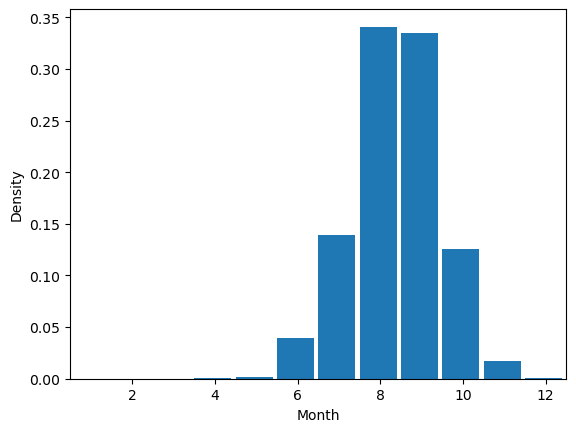

In [ ]:
basin_id = 'NA' # see ds['basin'] for a list of basin IDs
mask = ds['tc_basins'] == basin_id
plt.hist(ds['tc_month'].where(mask).load().data.flatten(),
         density = True, bins = np.arange(-0.5, 12.6, 1), width = 0.90)
plt.xlabel('Month'); plt.ylabel('Density')
plt.xlim([0.5, 12.5])

Next, we will calculate the interannual frequency predicted by the model. This is a little trickier, since we need to understand the random seeding process developed by Kerry Emanuel. The model randomly seeds storms every where, and evolves them in space and time. Most of the seeds die out, but a few survive, which are kept as the storms. Let's say that $N_{seeds}$ number of seeds were needed to generate $N_{storms}$ number of storms. Then the 'seed survival rate', $\Gamma$ can be defined as:
$$
    \Gamma = \frac{N_{\text{storms}}}{N_{\text{seeds}}}
$$
which has units storms per seed. Note, in order to convert this into a number of storms (i.e. a frequency), we need to multiply by a singular constant with units seeds. Here is where we assume a *fixed* seeding frequency across all years (see Emanuel 2022 for more nuanced discussion), $c$, with units seeds per year. Then, the frequency of storms per year, $f_{\text{storms}}$ is simply:
$$
    f_{\text{storms}} = c \Gamma
$$

In this model, $N_{\text{storms}}$ is set by the user (`tracks_per_year`), and $N_{\text{seeds}}$ is given by the model. However, $c$ is unknown, and can be thought of as a 'tuning' parameter. Here, we will determine $c$ by simply setting it so that the long term average of $f_{\text{storms}}$ is equal to the observed long-term average. However, we should be clear that the inherent assumptions here are a subject of open research.

Text(0, 0.5, 'Number of Storms')

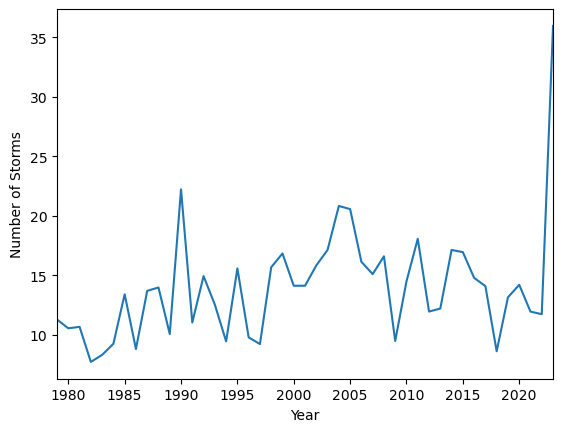

In [ ]:
# Total number of seeds, per month, needed to generate a fixed number
# of storms per year, summed across the 'ensemble members' (file).
total_seeds = ds['seeds_per_month'].sum('ensemble')
total_seeds_per_year = ds['seeds_per_month'].sum(['ensemble', 'month'])
total_seeds_per_year_NA = total_seeds_per_year.sel(basin = 'NA')

# Calculate interannual frequency, setting the average frequency
# equal to 'obs_tracks_per_year', by multiplying by a constant.
obs_tracks_per_year = 14    # should be calculated using observations
gamma = tracks_per_year / total_seeds_per_year_NA
c = obs_tracks_per_year / gamma.mean()  # seeding frequency constant
storm_freq = c * gamma

plt.plot(ds['year'], storm_freq)
plt.xlim([ds['year'][0], ds['year'][-1]])
plt.xlabel('Year'); plt.ylabel('Number of Storms')

Finally, in this section, we will include some sample analysis on retrieving return period analyses for singular points in space. It is important to remember here that generally, a large number of synthetic tracks are necessary to robustly estimate return period. However, for the purposes of this notebook, we will use just the five provided sample files, so the estimates will *not* be robust. We will use the procedure defined in Lin et al. (2025), which looks at the maximum intensity of all storms that pass within 100-km of a point, which we will choose to be Miami (feel free to set this to whatever point you'd like).

In [ ]:
# Haversine function, which calculates the great-circle
# distances between two points [lon1, lat1], [lon2, lat2].
def haversine(lon1, lat1, lon2, lat2):
    # Convert decimal degrees to radians
    lon1 = np.deg2rad(lon1)
    lat1 = np.deg2rad(lat1)
    lon2 = np.deg2rad(lon2)
    lat2 = np.deg2rad(lat2)

    # Use the Haversine formula.
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = (np.square(np.sin(dlat/2)) + np.cos(lat1) *
         np.cos(lat2) * np.square(np.sin(dlon/2)))
    c = 2 * np.arcsin(np.sqrt(a))

    r_earth = 6378000   # m
    km = (r_earth / 1000.) * c
    return(km)

# Point of interest longitude/latitude coordinates, Miami.
clat = 25.7617
clon = -80.1918

Now, we will use the powerful abilities of `xarray` to find the maximum intensity of each storm, when it is within 100-km of the selected point of interest.

In [ ]:
# Distance of each track from the selected point of interest.
dists = haversine(clon, clat, ds['lon_trks'], ds['lat_trks']).load()

# Find the maximum intensity of each storm, when it is within
# 100-km of the selected point of interest.
vmax_at_poi = ds['vmax_trks'].where(dists <= 100).max(dim = 'time').load()

Finally, to calculate the return period, notice that we have 2 ensemble members, each simulating 45 years of tropical cyclone activity. This is a total of 90 years, so we can estimate the intensity of up to the 1 in 90 year storm. As noted earlier, this is going to be subject to a lot of noise.

/tmp/ipykernel_1879985/2956843792.py:11: RuntimeWarning: divide by zero encountered in divide
  plt.plot(vmax_bins*1.94384, np.log(total_years / exceedance_count))


(50.0, 150.0)

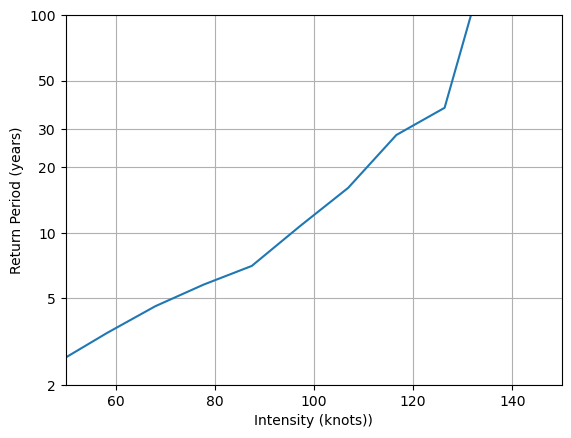

In [ ]:
total_years = len(ds['year']) * len(ds['ensemble'])

# Calculate the number of instances where a storm exceeded
vmax_bins = np.arange(10, 81, 5)
exceedance_count = np.zeros(len(vmax_bins))
vmax_at_poi_flat = vmax_at_poi.data.flatten()
for i in range(len(vmax_bins)):
    exceedance_count[i] = np.sum(vmax_at_poi_flat >= vmax_bins[i])

# Plot, on a log y-scale, the return period of the intensity
plt.plot(vmax_bins*1.94384, np.log(total_years / exceedance_count))
plt.yticks(np.log(np.array([2, 5, 10, 20, 30, 50, 100])),
           [2, 5, 10, 20, 30, 50, 100])
plt.xlabel('Intensity (knots))')
plt.ylabel('Return Period (years)')
plt.grid()
plt.ylim([np.log(2), np.log(100)])
plt.xlim([50, 150])